## Prepare

### Install dependencies
- `fastai` - machine learning library
- `librosa` - open `.wav` files and convert to spectrograms
- `matplotlib` - plot waveforms and save generated spectrograms as `.png` files

In [ ]:
!pip3 install fastai librosa matplotlib

### Download the training dataset

Source: https://magenta.tensorflow.org/datasets/nsynth

We only download the validation set, of 12k examples rather than the substantially larger training set, as it's a sufficient amount of data to experiment with. Download to the `training-data` directory in the root of the repository, so it can be shared by other projects and it is also part of `.gitignore`.

In [ ]:
import requests

url = 'http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz'
response = requests.get(url)

with open('../../training-data/nsynth-test.jsonwav.tar.gz', 'wb') as f:
    f.write(response.content)

### Extract the downloaded dataset

In [ ]:
import tarfile

with tarfile.open('../../training-data/nsynth-valid.jsonwav.tar.gz', 'r:gz') as f:
    f.extractall('../../training-data/')

### Load the example metadata

The metadata is located in `examples.json` in the extracted directory.

In [1]:
import json

examples = []
with open('../../training-data/nsynth-valid/examples.json') as f:
    examples = json.load(f)

first_20_examples = dict(list(examples.items())[:20])
first_example = list(examples.items())[0][1]

### Plot the first waveform spectrogram

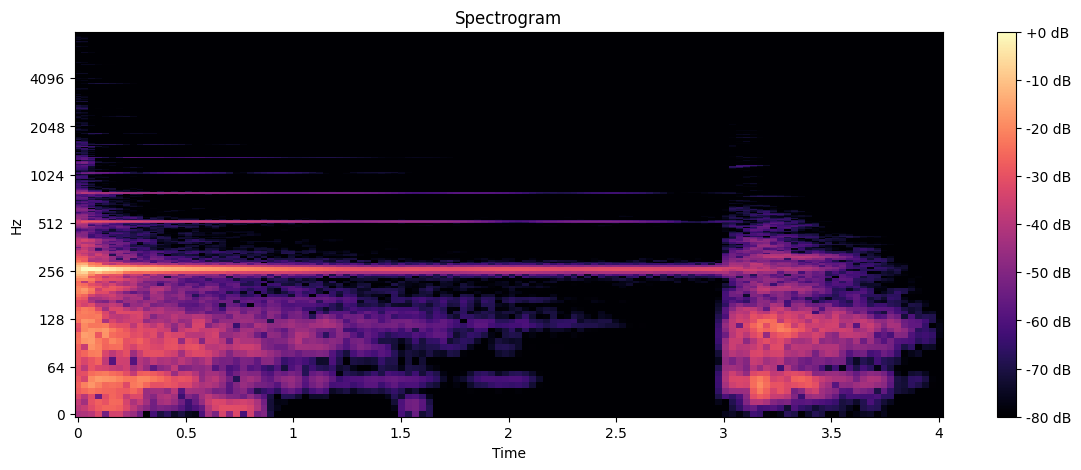

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
y, sample_rate = librosa.load('../../training-data/nsynth-valid/audio/' + first_example['note_str'] + '.wav', sr=first_example['sample_rate'])

# Compute the STFT
D = librosa.stft(y)

# Convert to dB
D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(D_db, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

### Determine the frequency from the MIDI note

For details on how MIDI notes are converted to frequencies, see [this link](https://newt.phys.unsw.edu.au/jw/notes.html). The frequency $f_{m}$ of the MIDI note with number $m$ is given by:

$$ f_m = 2^{(m - 69)/12} \times 440 \mathrm{Hz} $$

In [3]:
m = first_example['pitch']
def midi_frequency(m):
    return 440 * 2 ** ((m - 69) / 12)

print(f'The note has has MIDI number: {m}, corresponding to {midi_frequency(m)} Hz')

The note has has MIDI number: 60, corresponding to 261.6255653005986 Hz


## Creating the model

Our dataset consists of musical notes, which each correspond to particular frequencies. In practice, we may encounter musical notes that are not in tune, and frequency is a continuous number. Therefore, we will build a regression model, mapping a spectrogram to a single scalar value. Since musical notes are a power series in frequency, we take the log of the frequency. This way, a mean square error loss function will give us a loss proportional to the square offset in number of notes from the actual note.

### Building the Dataset

In [45]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import json
import random
from fastai.vision.all import *
import librosa

class SpectrogramDataset(Dataset):
    def __init__(self, path, examples=None, seed=42):
        self.path = path
        if examples is None:
            self.examples = list(json.load(open(f'{path}/examples.json')).items())
            self.examples.sort(key=lambda x: x[0])
        else:
            self.examples = examples
        if seed is not None:
            rng = random.Random(seed)
            rng.shuffle(self.examples)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return SpectrogramDataset(
                self.path, examples=self.examples[idx], seed=None)
        else:
            example = self.examples[idx]
            y, _ = librosa.load(f'{self.path}/audio/{example[0]}' + '.wav', sr=example[1]['sample_rate'])
            ft = librosa.stft(y)
            ft_db = librosa.amplitude_to_db(abs(ft), ref=np.max)

            # Convert to PyTorch tensor and add a channel dimension
            input_tensor = tensor(ft_db).unsqueeze(0)
            target_tensor = torch.log2(tensor(midi_frequency(example[1]['pitch'])))

            return input_tensor.float(), target_tensor.float()
        
    def get_metadata(self, idx):
        return self.examples[idx]

### Create the DataLoaders

In [46]:
ds = SpectrogramDataset('../../training-data/nsynth-valid')
ds_length = len(ds)

## Split the dataset into training and validation sets
train_ds = ds[:int(ds_length * 0.8)]
valid_ds = ds[int(ds_length * 0.8):]

dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, device=default_device())

### Check the DataLoaders

Since we've defined our own `Dataset`, `fastai` doesn't know how to render our data batches automatically. We'll have to write our own code to display some examples to check they look sensible.

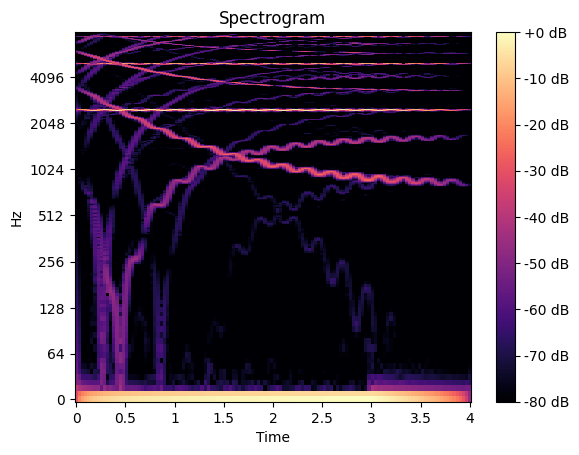

Frequency: 2489.015869140625


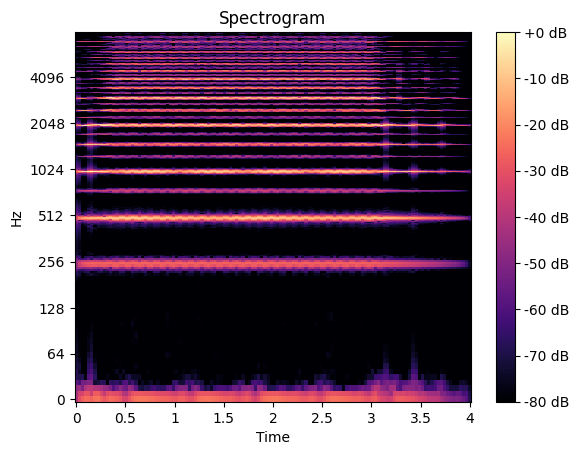

Frequency: 493.8833923339844


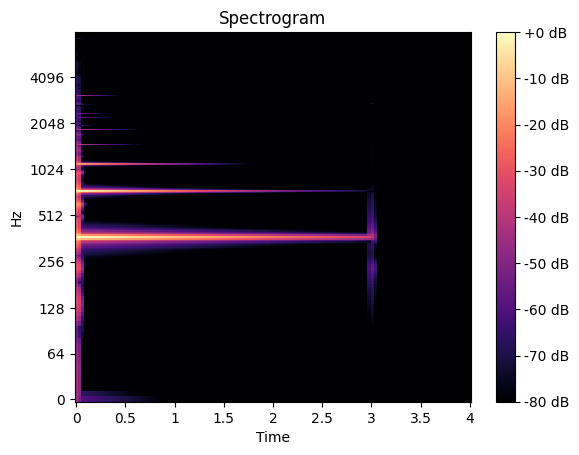

Frequency: 369.9944152832031


In [6]:
import matplotlib.pyplot as plt

xs, ys = dls.one_batch()
for idx in range(3):
    x, y = xs[idx][0], ys[idx]
    
    librosa.display.specshow(np.array(x.to('cpu')), sr=16000, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    print(f'Frequency: {2 ** y}')

### Create the learner

We create a vision learner with a single scalar output. We are working with spectrogram data, which only has a single channel as opposed to the three (RGB) channels for image data. We therefore have to swap out the first layer of our neural network as well. Swapping out the first layer would randomise its weights and cause the weights in the remaining layers to be effectively useless. However, we can simply set the values of the weights in the new first layer as the average of the original pretrained weights between the RGB channels.

In [7]:
learner = vision_learner(
    dls, resnet34, 
    n_in=1, # spectrograms have a single channel 
    n_out=1, # the target is a single number
    loss_func=MSELossFlat(), 
    metrics=[mae],
    cbs=MixUp())

### Train the model

We once again train the model in two stages: we first train the head which strated with random weights, and then we unfreeze and train the whole model.

We are using `MixUp`, which creates linear combinations of pairs of input tensors during training and expects that they result in equivalent linear cominations of their respective outputs. This helps to ensure that the model generalises better and means we are able to train for longer than usual without overfitting the training the set.

In [8]:
learner.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,mae,time
0,42.417973,27.995062,5.139184,03:08
1,5.816821,2.252227,1.127945,03:03
2,2.955927,0.748716,0.652541,03:04
3,2.013226,0.587020,0.583518,03:05
4,1.675313,0.324992,0.428984,03:07
5,1.660754,0.263821,0.379365,03:08


In [9]:
learner.unfreeze()
learner.fit_one_cycle(80, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,mae,time
0,1.540214,0.274342,0.392867,04:26
1,1.585713,0.223364,0.353737,04:26
2,1.433130,0.264746,0.393749,04:26
3,1.524211,0.259916,0.387948,04:22
4,1.413236,0.237124,0.352583,04:20
5,1.289329,0.180250,0.312758,04:22
6,1.184991,0.261982,0.403422,04:18
7,1.189283,0.290511,0.406140,04:23
8,1.088881,0.157151,0.286860,04:23
9,1.077235,0.308982,0.436311,04:18


We'd like to make a realistic comparison of our final training and validation loss to know if we are overfitting the training set. The values printed in the table above are misleading, since training was conducted using `MixUp` and there is also a Dropout layer in the head of the model which is only active during training.

In [15]:
learner.validate(ds_idx=0)

(#2) [0.021076709032058716,0.11161752045154572]

It appears that we are overfitting slightly, but since the validation loss and metrics stabilised above, rather than going back up, it indicates that our model has converged and is performing well.

### Testing out the model

First, we simply confirm that we can use the model as expected and get sensible outputs:

In [18]:
def midi_note(freq):
    return 69 + 12 * np.log2(freq / 440)

for example in list(first_20_examples.items())[0:5]:
    y, _ = librosa.load(f'../../training-data/nsynth-valid/audio/{example[0]}.wav')
    ft = librosa.stft(y)
    ft_db = librosa.amplitude_to_db(abs(ft), ref=np.max)
    input_tensor = tensor(ft_db).unsqueeze(0).unsqueeze(0).to(default_device())

    output_tensor, _, _ = learner.predict(input_tensor.float())
    midi_note_output = midi_note(2 ** output_tensor.item())
    
    print(f'Actual note: {example[1]["pitch"]}, predicted note: {midi_note_output}')
    print(f'Actual frequency: {midi_frequency(example[1]["pitch"])}, predicted frequency: {2 ** output_tensor.item()}')
    print('')

Actual note: 60, predicted note: 62.77142666280174
Actual frequency: 261.6255653005986, predicted frequency: 307.0461994111517



Actual note: 50, predicted note: 56.98666714131737
Actual frequency: 146.8323839587038, predicted frequency: 219.83063527956276



Actual note: 52, predicted note: 56.46438167989159
Actual frequency: 164.81377845643496, predicted frequency: 213.29773764663705



Actual note: 64, predicted note: 66.77569149434471
Actual frequency: 329.6275569128699, predicted frequency: 386.9492817234263



Actual note: 30, predicted note: 37.65535305440331
Actual frequency: 46.2493028389543, predicted frequency: 71.96910446321316



Predictions are within several notes of the actual values, which is in line with our final loss metrics. Let's dig in further and see the top losses:

In [27]:
interp = Interpretation.from_learner(learner)

top_losses = interp.top_losses(10)

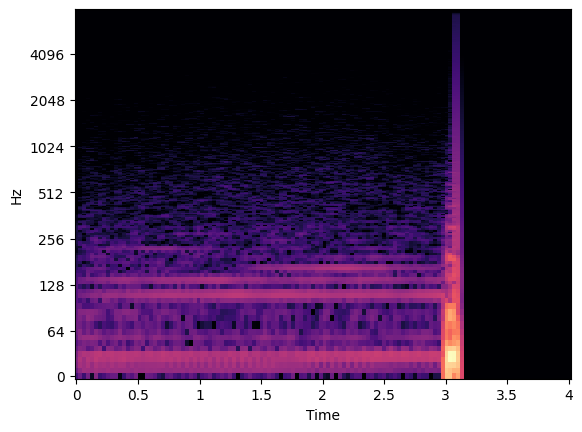

Note name: guitar_acoustic_030-021-025
L2 loss: 11.27072525024414, L1 loss: 3.3571901321411133
Actual frequency: 27.5
Predicted frequency: 281.80429790582815


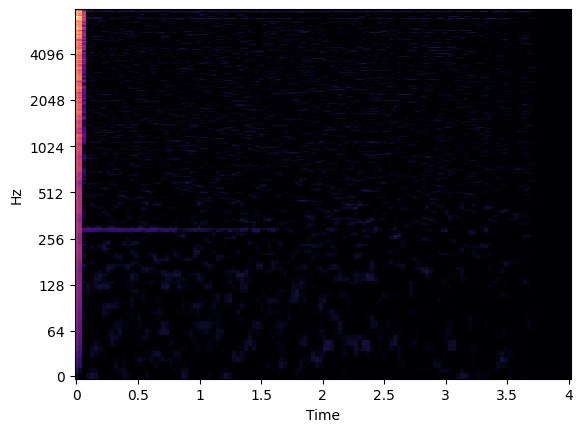

Note name: mallet_acoustic_056-119-127
L2 loss: 0.7381238341331482, L1 loss: 0.8591413497924805
Actual frequency: 7902.13427734375
Predicted frequency: 4356.2930938370455


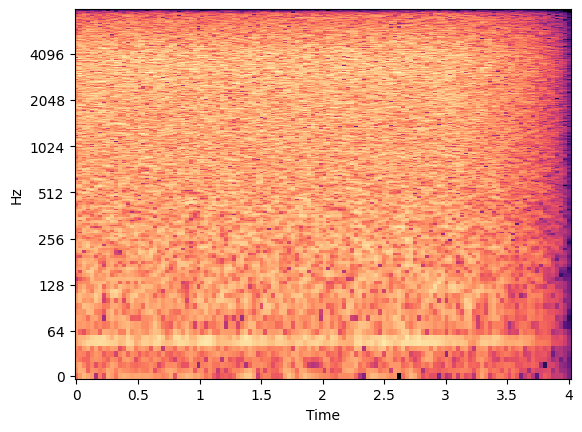

Note name: brass_acoustic_046-084-050
L2 loss: 0.6937081813812256, L1 loss: 0.8328914642333984
Actual frequency: 1046.502197265625
Predicted frequency: 1864.0839734297915


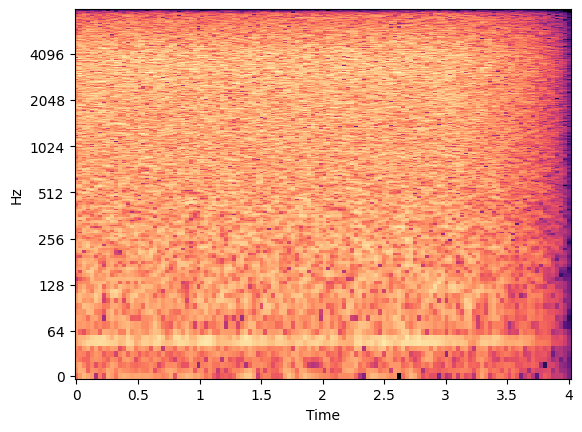

Note name: brass_acoustic_046-102-050
L2 loss: 0.4450337886810303, L1 loss: 0.6671085357666016
Actual frequency: 2959.955322265625
Predicted frequency: 1864.0839734297915


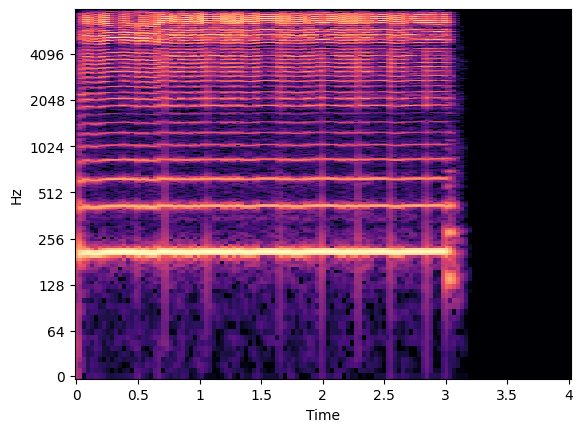

Note name: brass_acoustic_016-056-127
L2 loss: 0.4076307713985443, L1 loss: 0.6384596824645996
Actual frequency: 207.65231323242188
Predicted frequency: 323.24536264949444


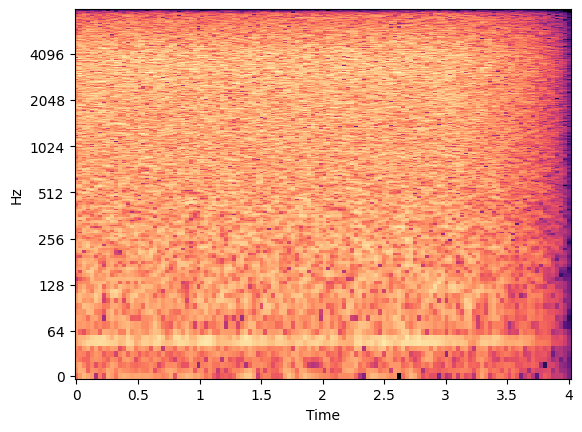

Note name: brass_acoustic_046-087-075
L2 loss: 0.33976244926452637, L1 loss: 0.5828914642333984
Actual frequency: 1244.5079345703125
Predicted frequency: 1864.0839734297915


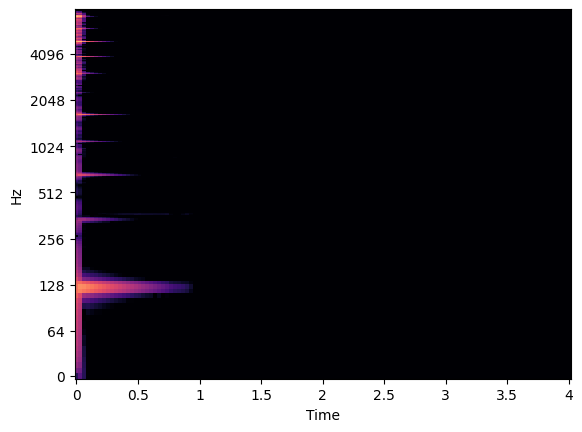

Note name: mallet_acoustic_056-047-025
L2 loss: 0.3257226347923279, L1 loss: 0.5707211494445801
Actual frequency: 123.47080993652344
Predicted frequency: 183.38697046324566


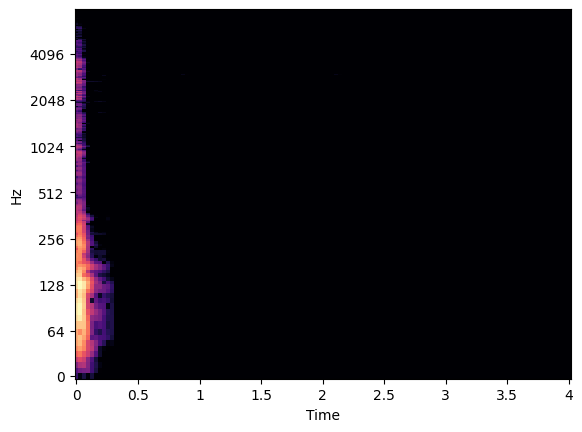

Note name: bass_electronic_027-022-100
L2 loss: 0.3163735270500183, L1 loss: 0.5624709129333496
Actual frequency: 29.135236740112305
Predicted frequency: 43.02681297561323


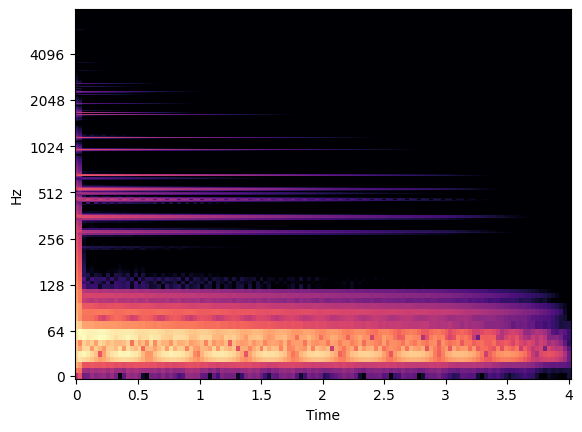

Note name: mallet_acoustic_062-022-127
L2 loss: 0.2605990171432495, L1 loss: 0.5104889869689941
Actual frequency: 29.135236740112305
Predicted frequency: 41.50410564352032


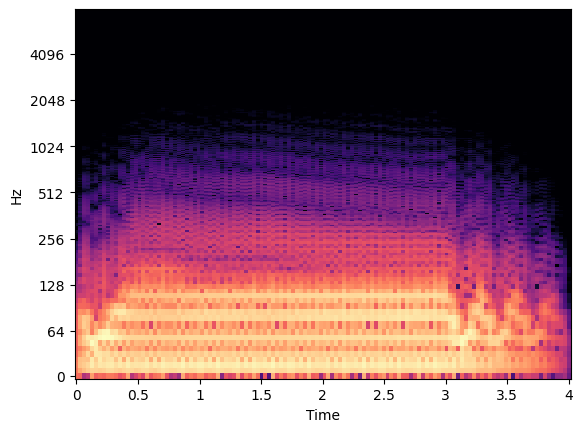

Note name: organ_electronic_007-009-100
L2 loss: 0.2538590431213379, L1 loss: 0.5038442611694336
Actual frequency: 13.75
Predicted frequency: 19.497320088760006


In [49]:
for loss in zip(top_losses[0], top_losses[1]):
    x, y = valid_ds[loss[1]]
    predicted = learner.predict(x.unsqueeze(0))[0].item()
    metadata = valid_ds.get_metadata(loss[1])
    librosa.display.specshow(np.array(x[0].to('cpu')), sr=16000, x_axis='time', y_axis='log')
    plt.show()
    print(f'Note name: {metadata[1]["note_str"]}')
    print(f'L2 loss: {loss[0].item()}, L1 loss: {abs(predicted - y)}')
    print(f'Actual frequency: {2 ** y}')
    print(f'Predicted frequency: {2 ** predicted}')

It appears that the largest losses are:
- an single outlier very low frequency guitar note
- brass and mallet notes